# Introduction
Inspired by predicting sales of things dependent of multivariate observations (eg day of week, holidays) and so on

## Prepare data
Before using deflate train and test data that has been downloaded before (kaggle competitions download -c rossmann-store-sales).

```
unzip -d ./input/rossmann-store-sales.zip ./input/
```

## Further literature
- [kaggle competition](https://www.kaggle.com/c/rossmann-store-sales)
- https://www.mdpi.com/2306-5729/4/1/15
- http://cs229.stanford.edu/proj2015/205_report.pdf


# Preprocessing
Feature engineering, create categorial columns

In [159]:
import pandas as pd
from pandas import DataFrame

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

df_train: DataFrame = pd.read_csv('./input/train.csv', parse_dates=['Date'], dtype={'StateHoliday': str, 'Open': bool, 'Promo': bool, 'SchoolHoliday': bool})

# FEATURE ENGINEERING
## month
df_train['Month'] = pd.DatetimeIndex(df_train['Date']).to_period('M')
df_train['Year'] = pd.DatetimeIndex(df_train['Date']).to_period('Y')
df_train['Month_str'] = df_train['Month'].map(lambda month_period:month_period.strftime('%Y-%m'))

## StateHoliday -> categorial
df_train['StateHoliday'] = df_train['StateHoliday'].astype('category')

## StateHoliday -> categorial
df_train['DayOfWeek'] = df_train['DayOfWeek'].astype('category')

df_train.info()
df_train.head(5)



# ==== MONTHLY sales =====
s_sales_monthly: pd.Series = df_train.groupby(by=['Store', 'Month']).Sales.sum()
df_sales_monthly = s_sales_monthly.reset_index(drop=False) # Sets columns of MUltiIndex as columns of
df_sales_monthly['Month_str'] = df_sales_monthly['Month'].map(lambda month_period:month_period.strftime('%Y-%m'))
df_sales_monthly['Year'] = df_sales_monthly['Month'].map(lambda month_period:month_period.strftime('%Y')).astype('int64')
# dataframe with drop=False
df_sales_monthly.info()
df_sales_monthly.head(10)






<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 12 columns):
 #   Column         Non-Null Count    Dtype         
---  ------         --------------    -----         
 0   Store          1017209 non-null  int64         
 1   DayOfWeek      1017209 non-null  category      
 2   Date           1017209 non-null  datetime64[ns]
 3   Sales          1017209 non-null  int64         
 4   Customers      1017209 non-null  int64         
 5   Open           1017209 non-null  bool          
 6   Promo          1017209 non-null  bool          
 7   StateHoliday   1017209 non-null  category      
 8   SchoolHoliday  1017209 non-null  bool          
 9   Month          1017209 non-null  period[M]     
 10  Year           1017209 non-null  period[A-DEC] 
 11  Month_str      1017209 non-null  object        
dtypes: bool(3), category(2), datetime64[ns](1), int64(3), object(1), period[A-DEC](1), period[M](1)
memory usage: 59.2+ MB


,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Month,Year,Month_str
0,1,5,2015-07-31,5263,555,True,True,0,True,2015-07,2015,2015-07
1,2,5,2015-07-31,6064,625,True,True,0,True,2015-07,2015,2015-07
2,3,5,2015-07-31,8314,821,True,True,0,True,2015-07,2015,2015-07
3,4,5,2015-07-31,13995,1498,True,True,0,True,2015-07,2015,2015-07
4,5,5,2015-07-31,4822,559,True,True,0,True,2015-07,2015,2015-07


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33485 entries, 0 to 33484
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype    
---  ------     --------------  -----    
 0   Store      33485 non-null  int64    
 1   Month      33485 non-null  period[M]
 2   Sales      33485 non-null  int64    
 3   Month_str  33485 non-null  object   
 4   Year       33485 non-null  int64    
dtypes: int64(3), object(1), period[M](1)
memory usage: 1.3+ MB


,Store,Month,Sales,Month_str,Year
0,1,2013-01,128431,2013-01,2013
1,1,2013-02,125271,2013-02,2013
2,1,2013-03,145169,2013-03,2013
3,1,2013-04,118009,2013-04,2013
4,1,2013-05,118225,2013-05,2013
5,1,2013-06,113411,2013-06,2013
6,1,2013-07,128032,2013-07,2013
7,1,2013-08,118320,2013-08,2013
8,1,2013-09,108867,2013-09,2013
9,1,2013-10,114641,2013-10,2013


Plot monthly sales per Store

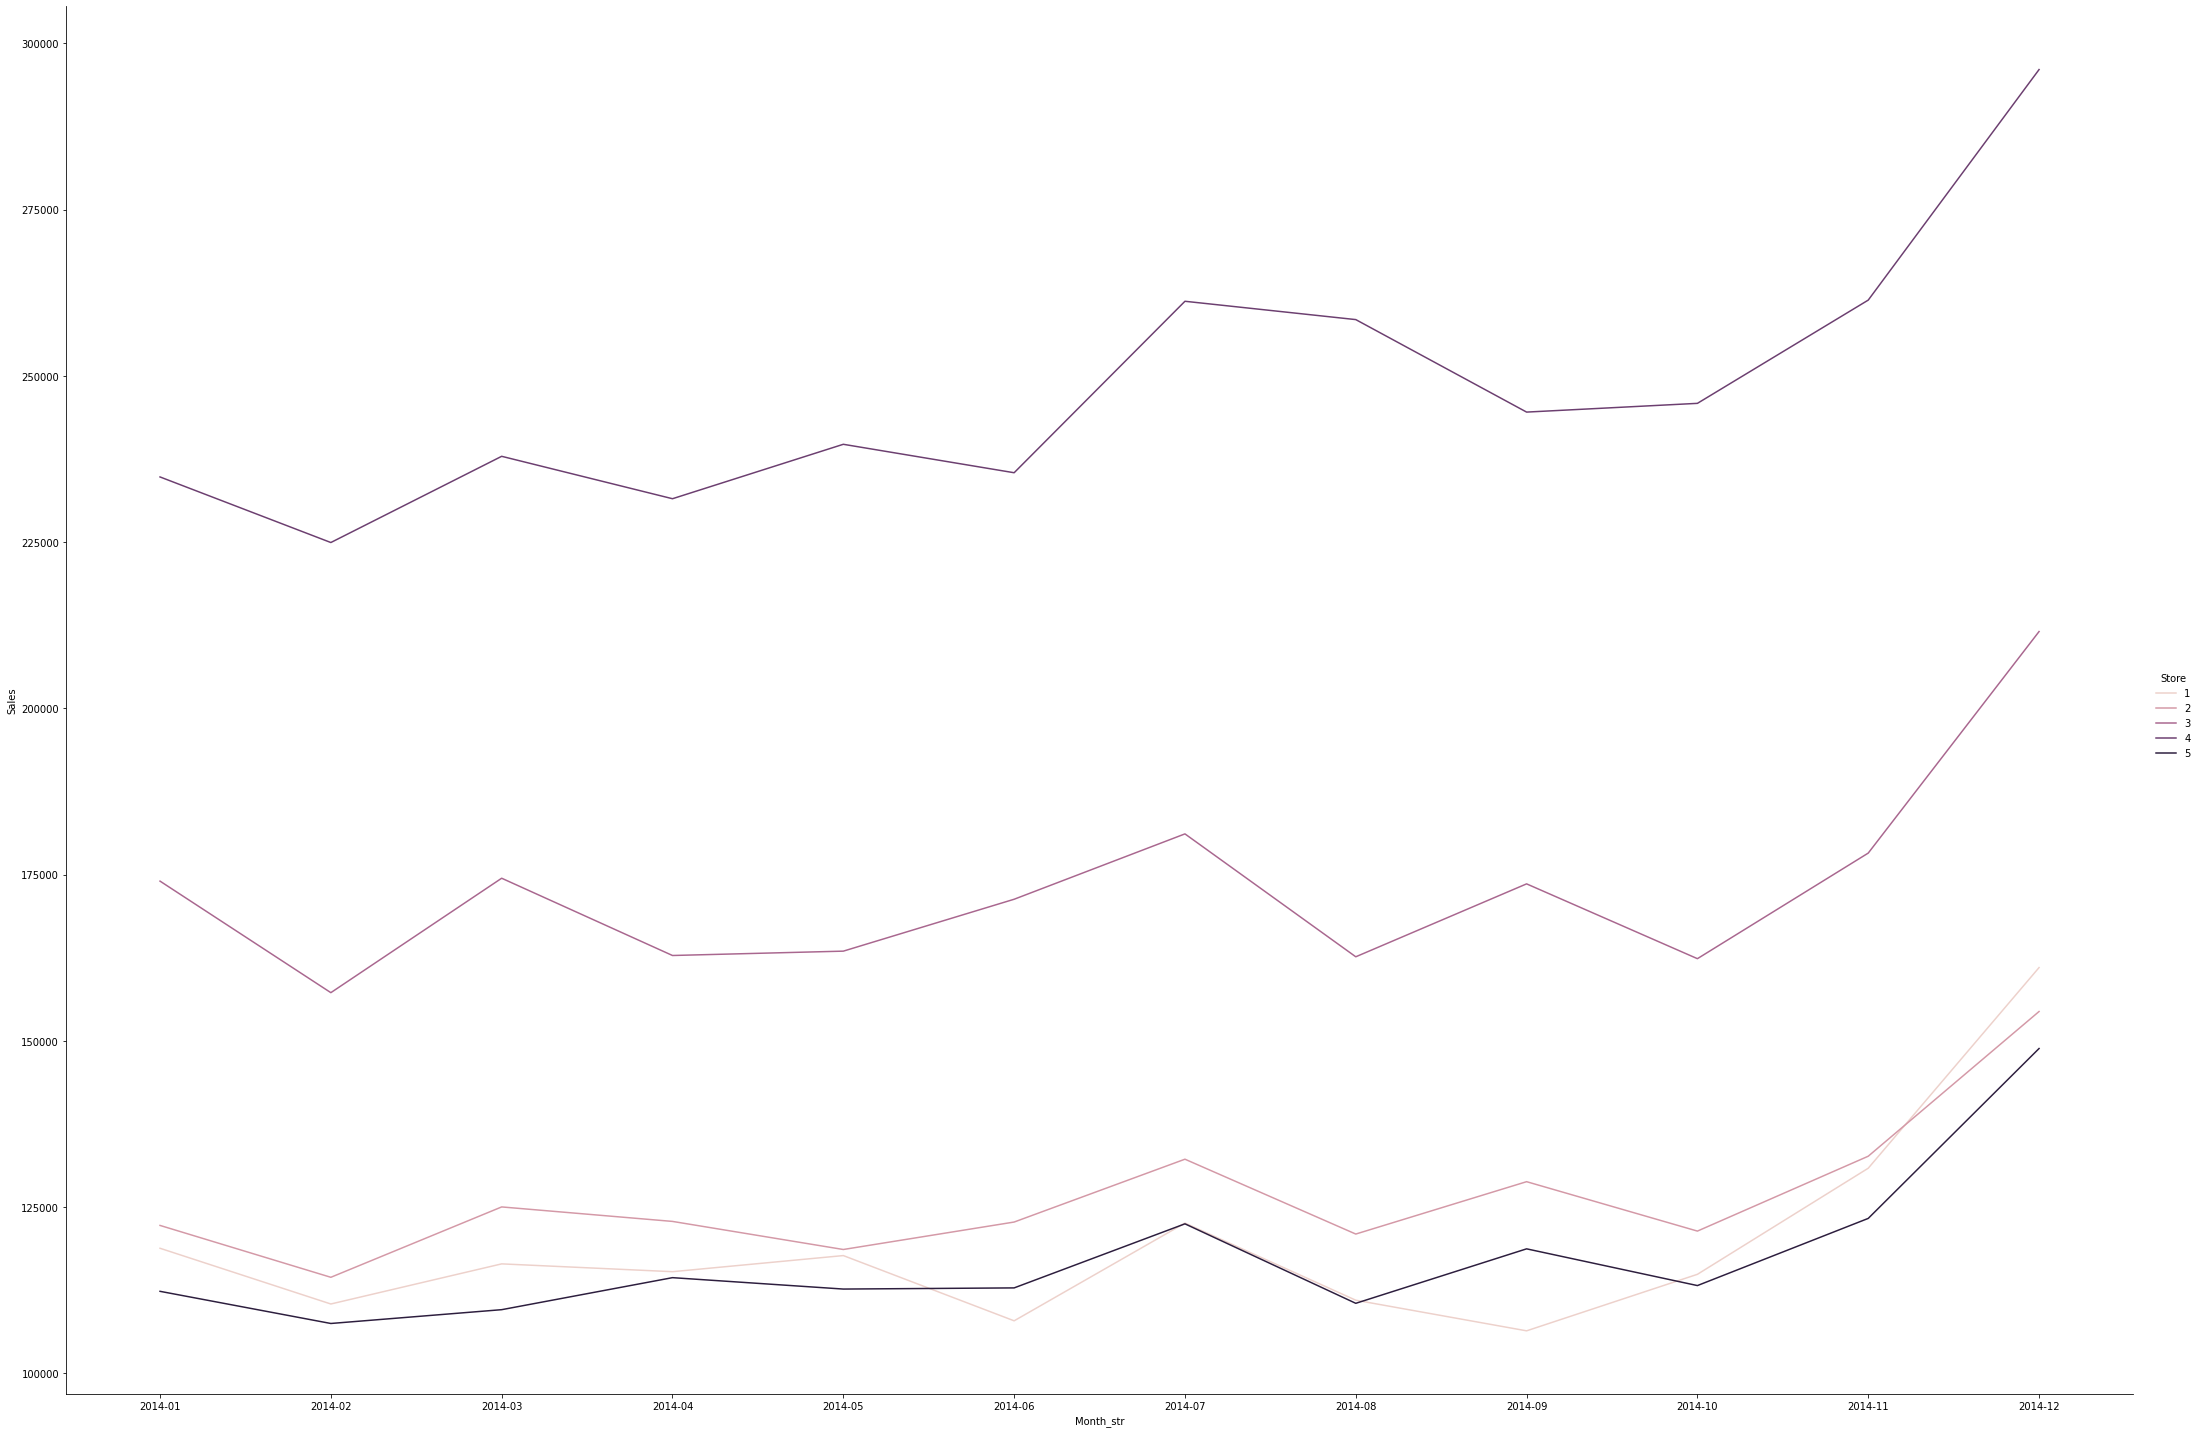

In [160]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count of month per Store
#print(df_sales_monthly.groupby(by=['Store']).count())

df_sales_monthly_stores_range = df_sales_monthly[(df_sales_monthly['Store'] < 6) & (df_sales_monthly['Store'] > 0)]

# First n stores
df_train_stores_range: DataFrame = df_train[(df_train['Store'] < 6) & (df_train['Store'] > 0)]
#df_train_stores_5.head(10)

# Monthly sales hue'ed by n Stores for one year
sns.relplot(data=df_sales_monthly_stores_range[df_sales_monthly_stores_range['Year'] == 2014], x="Month_str", y="Sales", hue="Store", kind='line', height=20.0, aspect=1.5)
plt.show()

# Per store analysis
In the following analysis per ONE store id is done and data prepared to be able to forecast sales for one store

## Seasonality
A time series is periodic if it repeats itself at equally spaced intervals, say, every 12 months, every 1 week, every 4 months, and so on.
Let us check if our time series has some seasonality element to it.

If yes, we can forecast entire weeks.

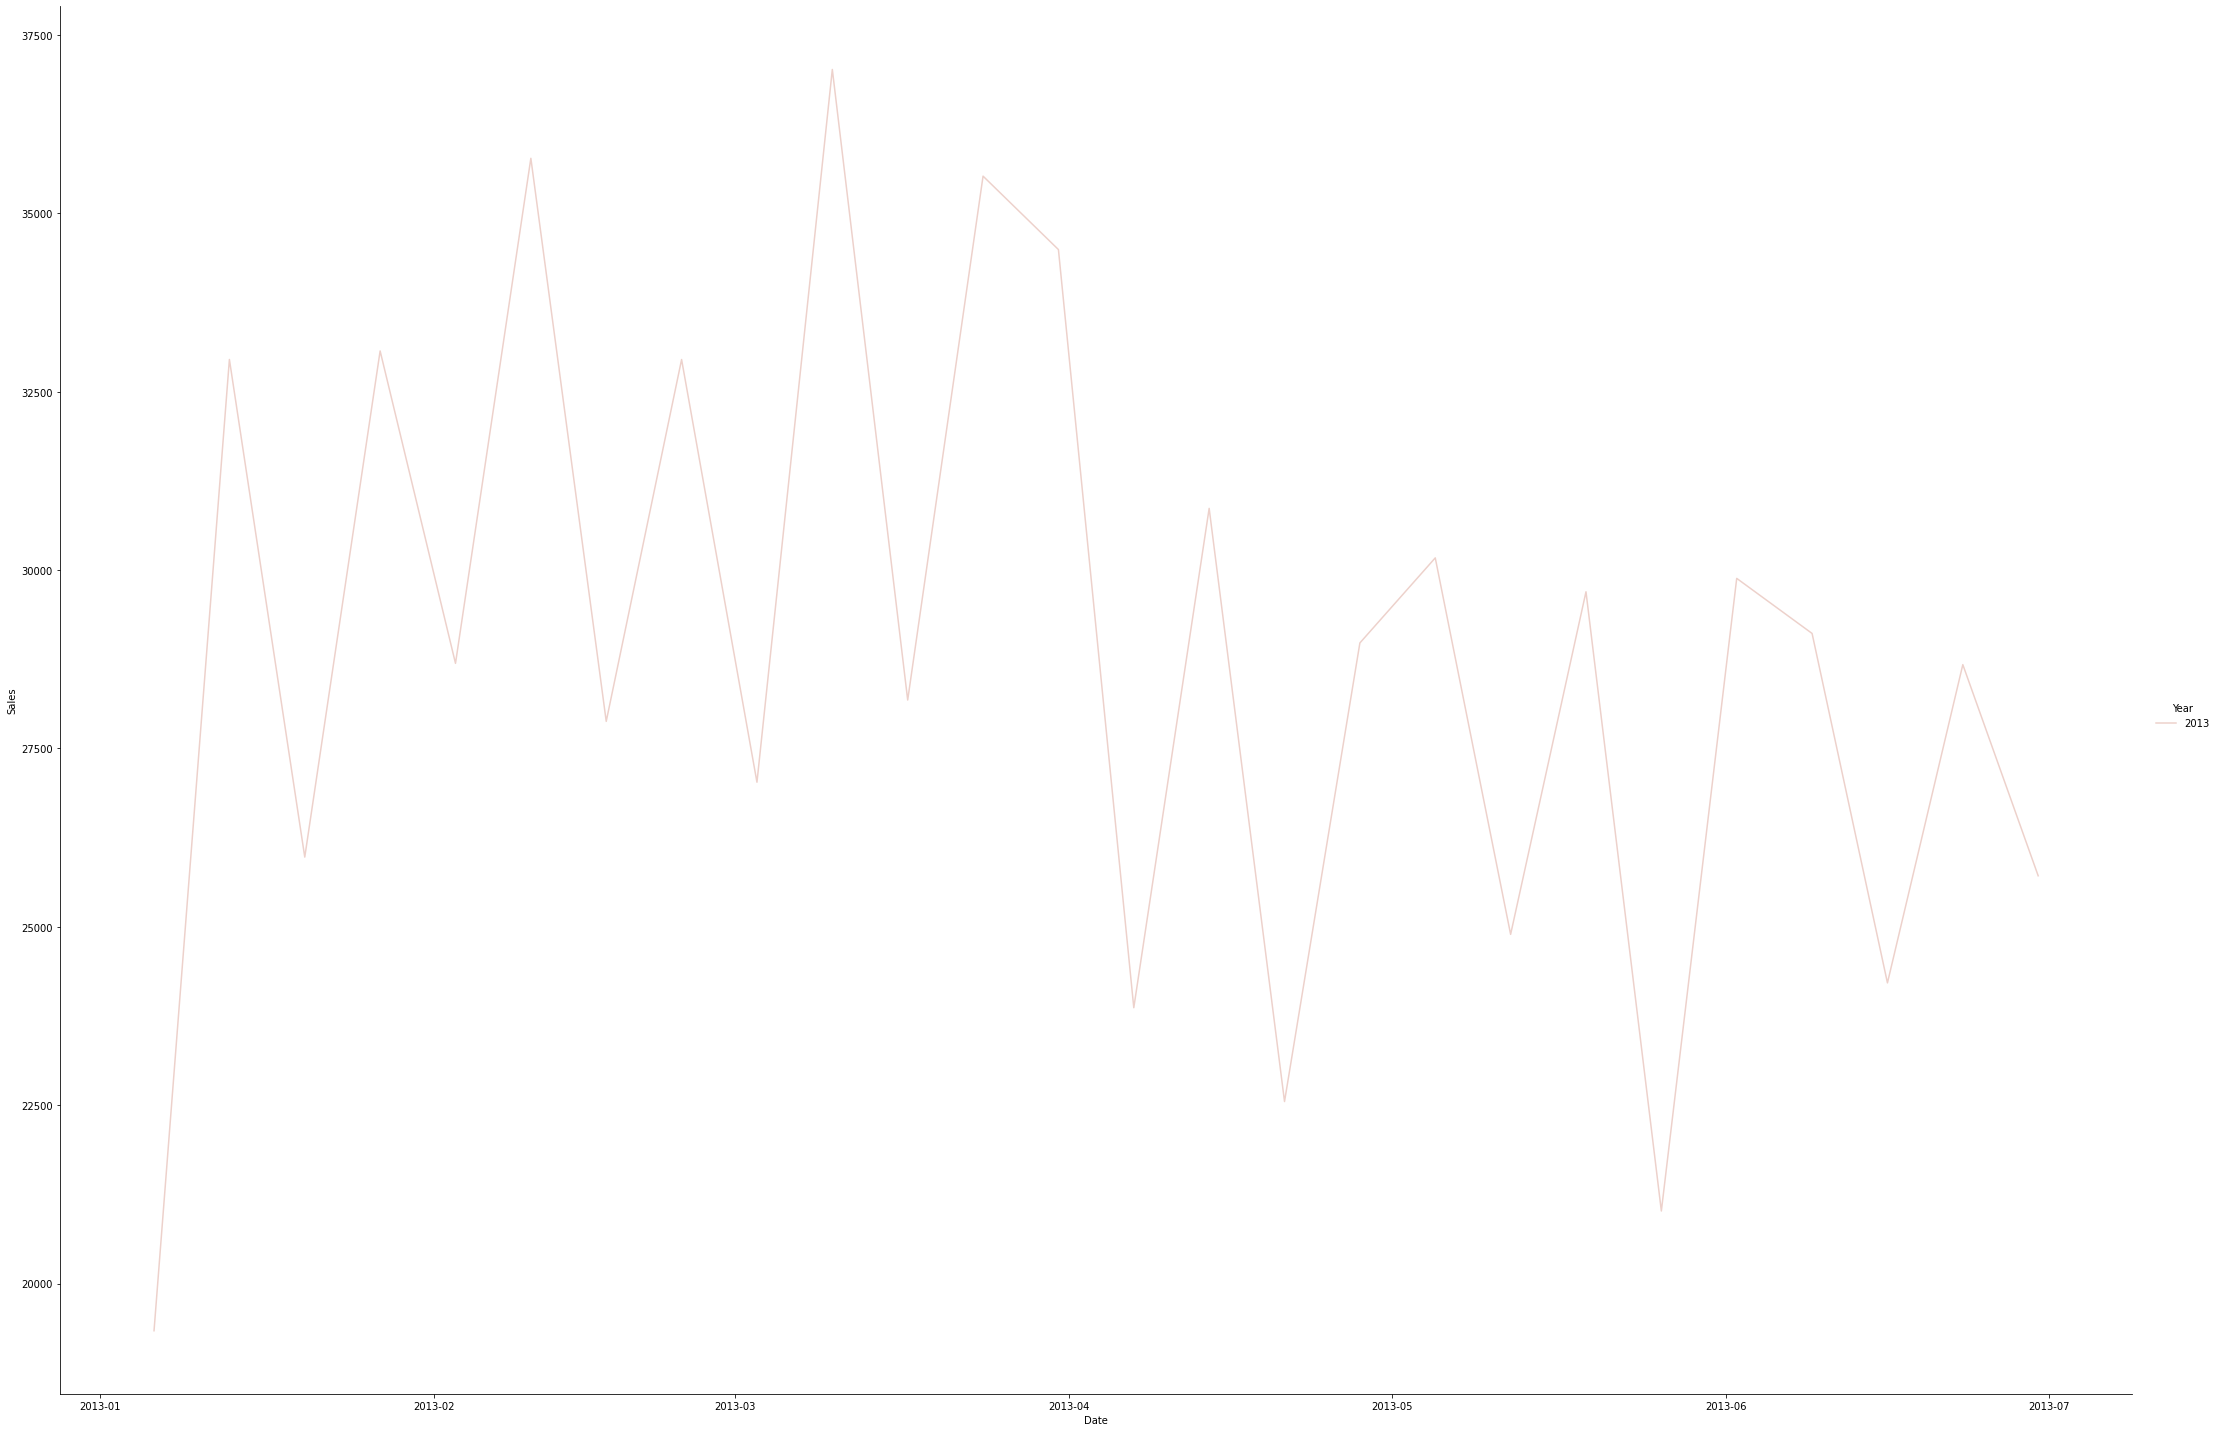

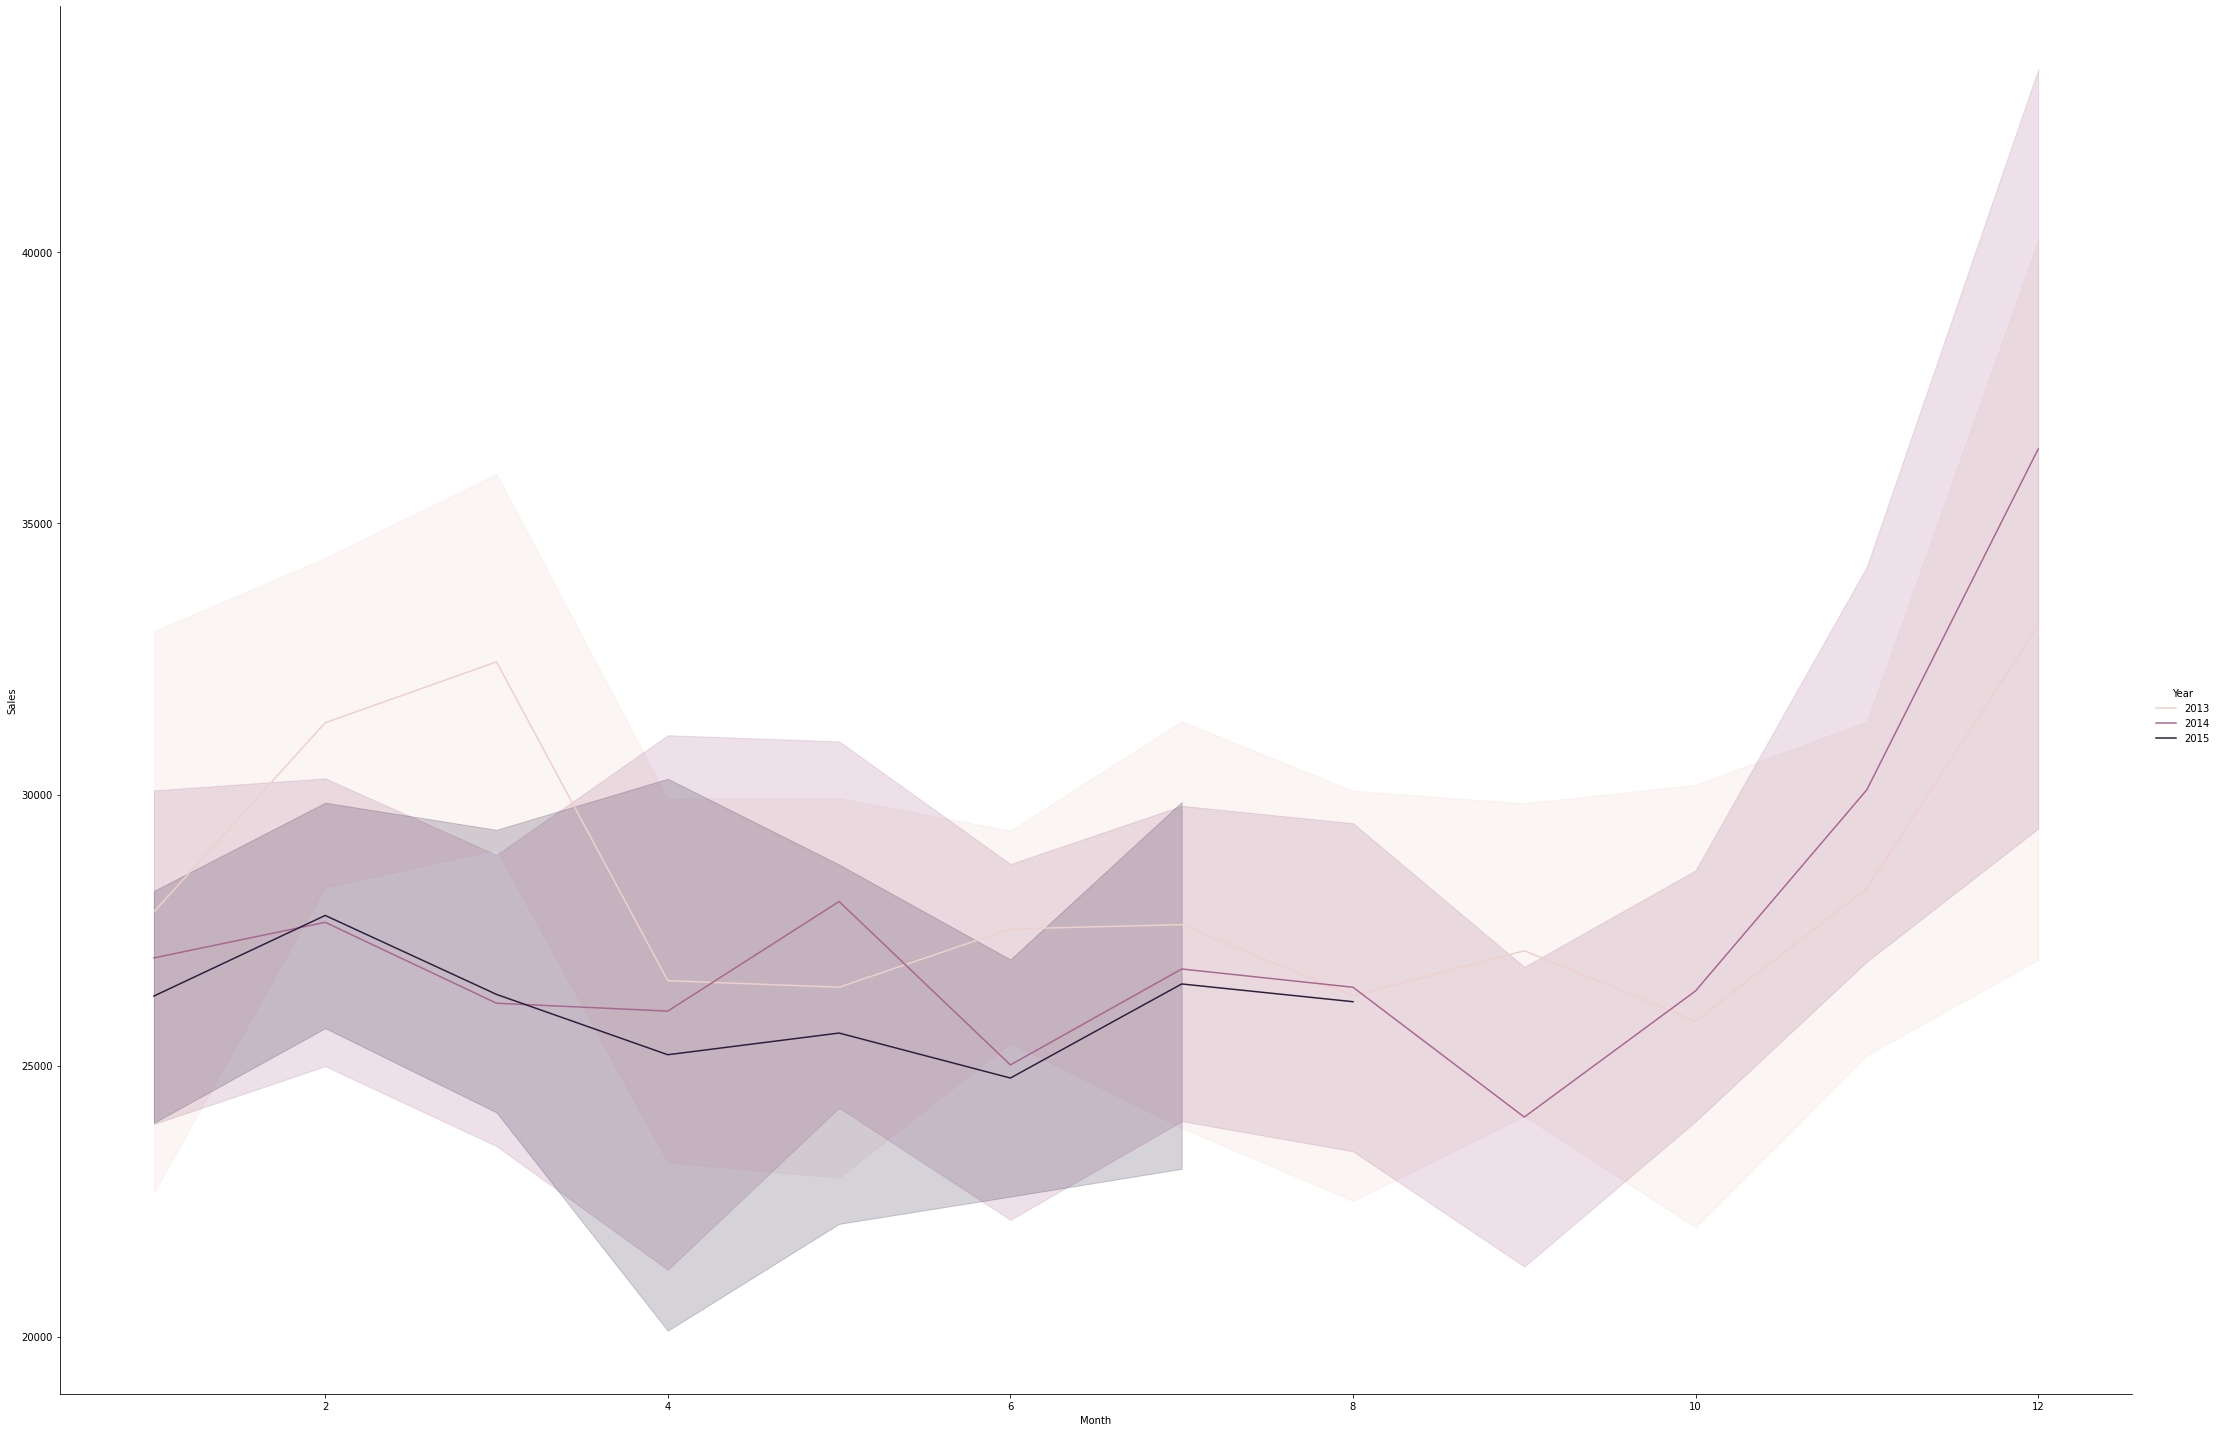

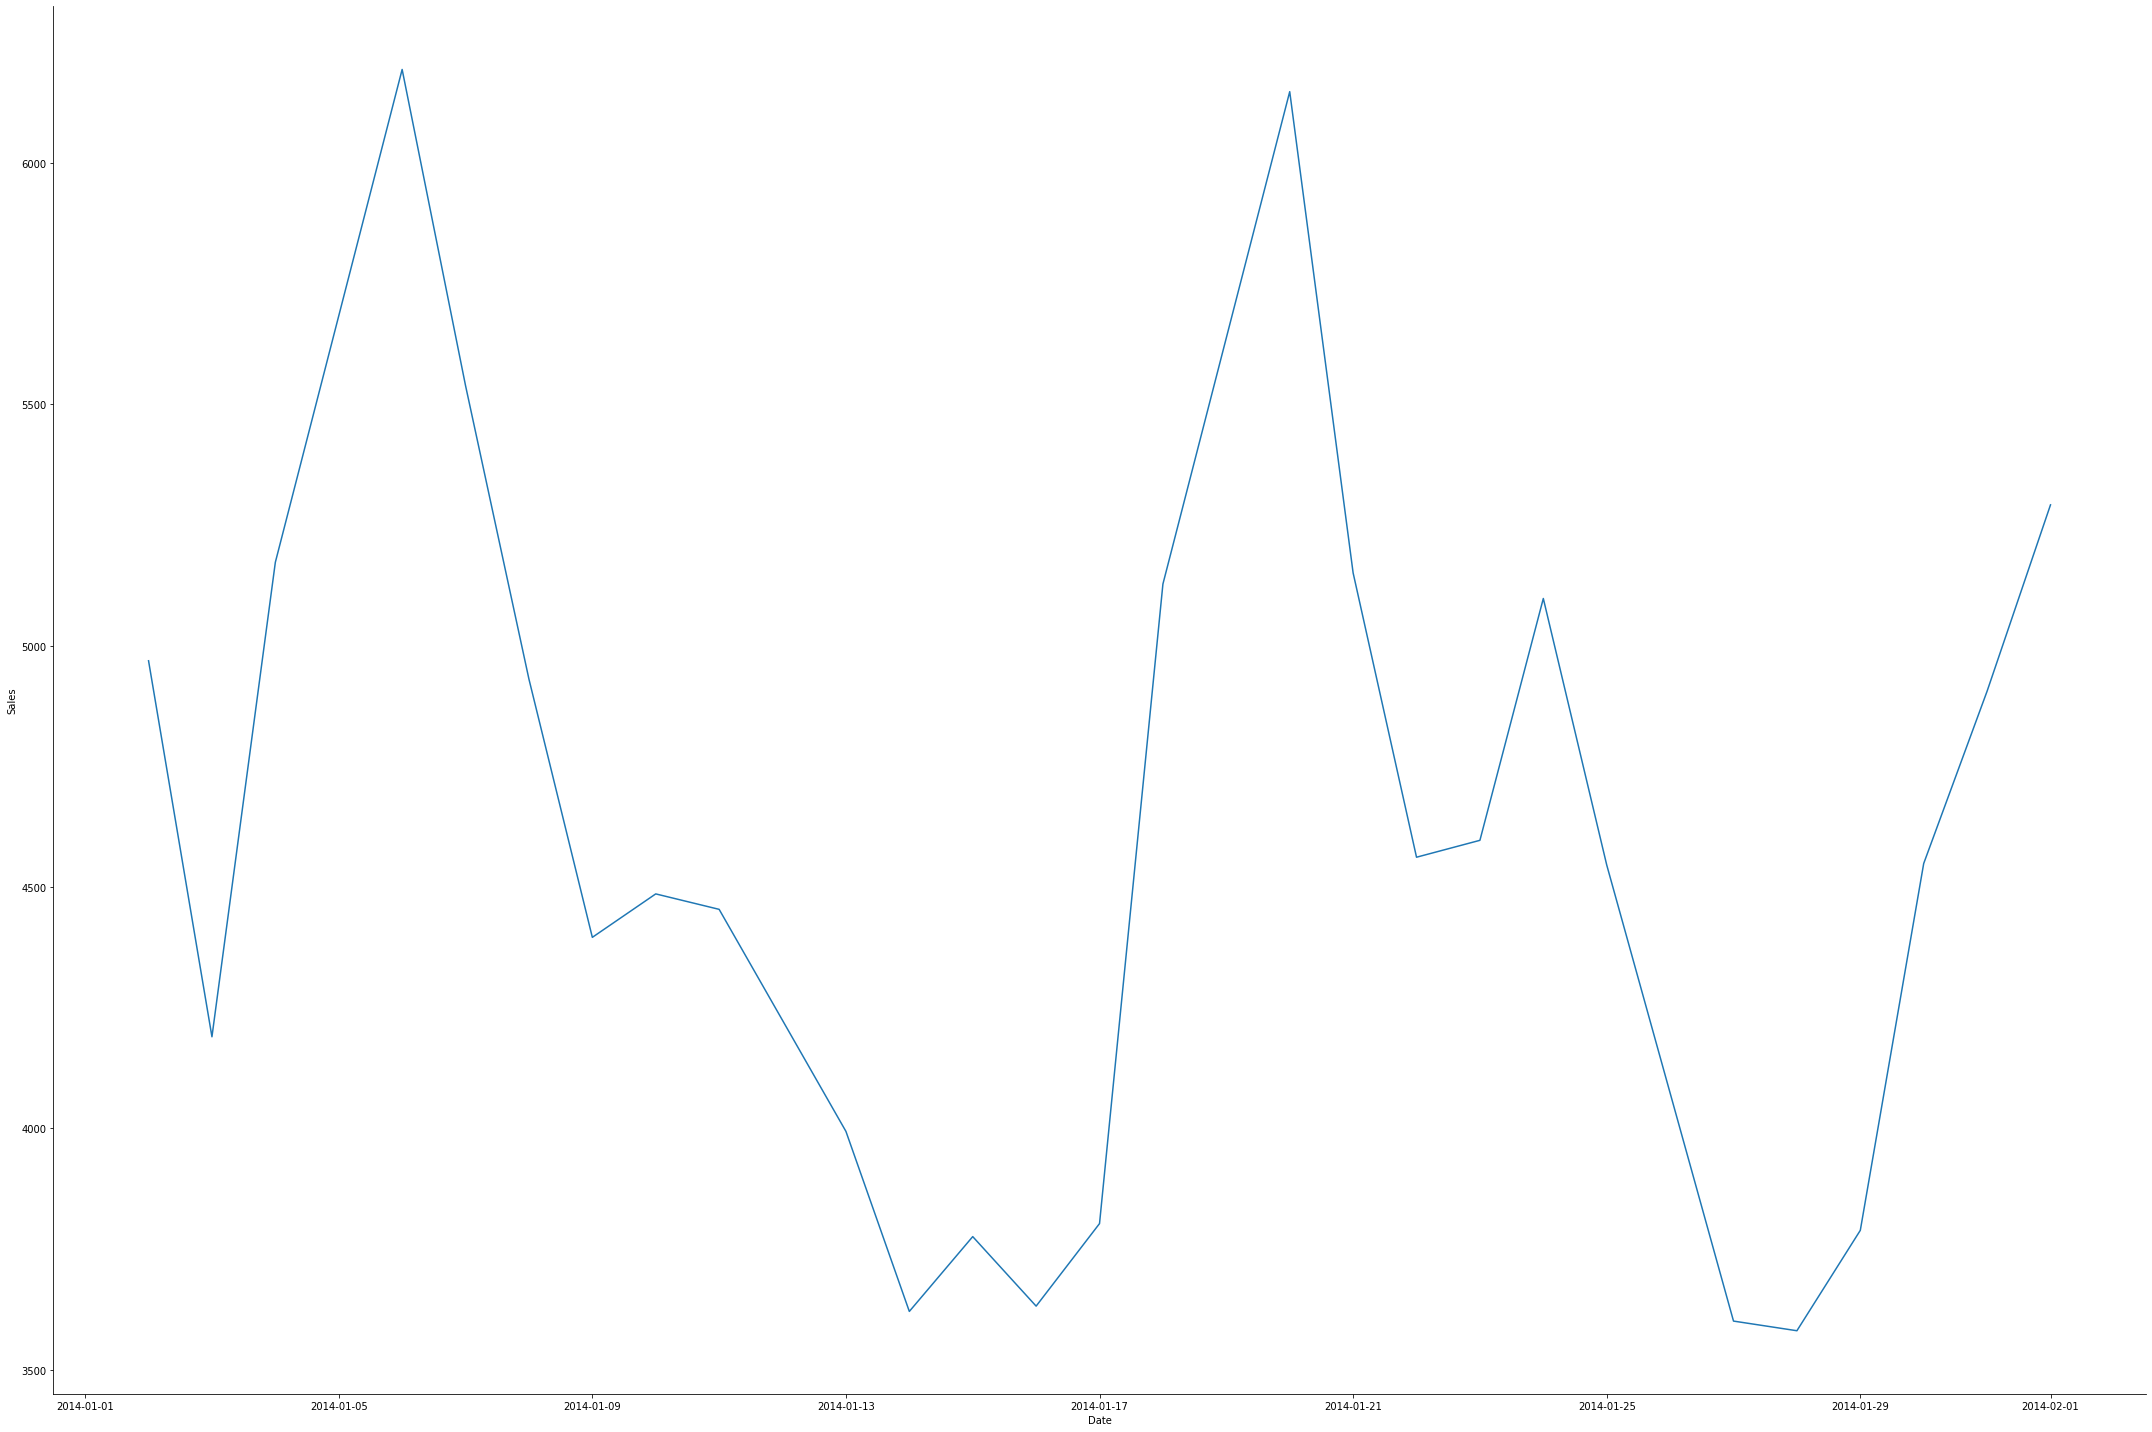

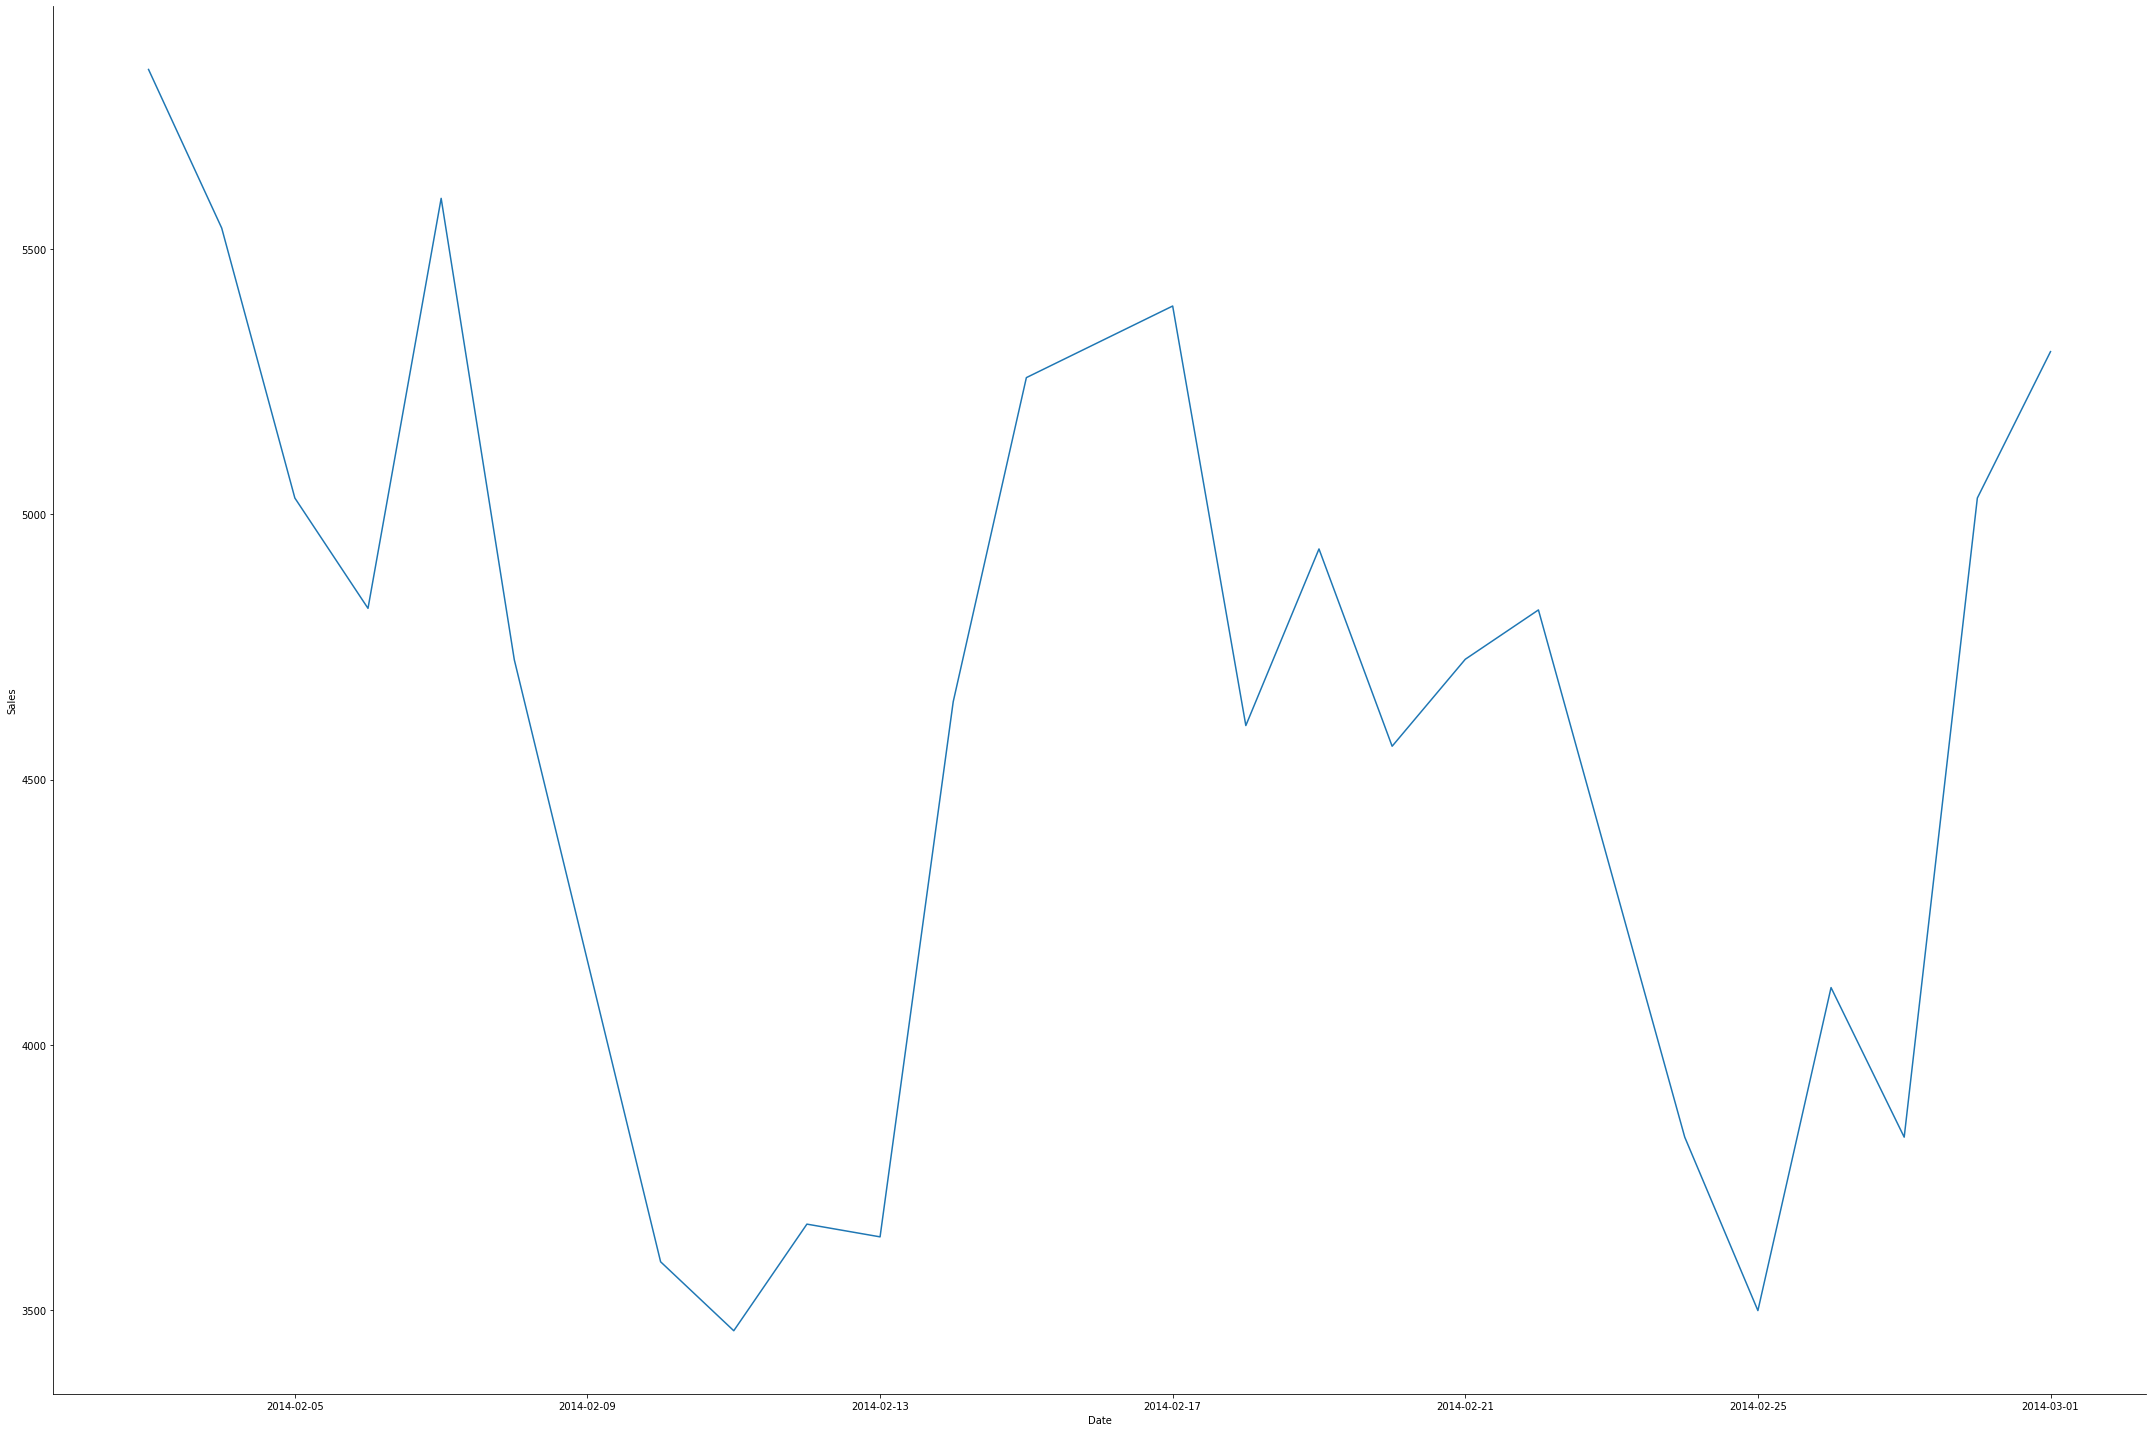

In [161]:
from pandas.plotting import lag_plot
import seaborn as sns
import matplotlib.pyplot as plt

# Grouped by Store
df_train_stores = df_train.groupby(by=['Store'])
#df_train_stores.Date.max()
#df_train_stores.Date.min()
df_train_store_1 = df_train_stores.get_group(1).set_index('Date')
sales_zero_idx = df_train_store_1[df_train_store_1['Sales'] == 0].index
df_train_store_1 = df_train_store_1.drop(sales_zero_idx)
#df_train_store_1['2015-01-01':'2015-02-01'].tail(10)

# resample/groupby WEEK
df_store_1_weekly_sum: DataFrame = df_train_store_1.resample("W").sum()
df_store_1_weekly_sum['Year'] = df_store_1_weekly_sum.index.year
df_store_1_weekly_sum['Month'] = df_store_1_weekly_sum.index.month
#df_store_1_weekly_sum['Week'] = df_store_1_weekly_sum.index.map(lambda week: week.strftime('%m-%d'))
#df_store_1_weekly_sum.head(10)

# resample/groupby MONTH
df_store_1_monthly_sum: DataFrame = df_train_store_1.resample("M").sum()
#df_store_1_monthly_sum.head(10)

sns.relplot(data=df_store_1_weekly_sum.loc['2013-01':'2013-06'].reset_index(),
            x='Date',
            y='Sales',
            hue='Year',
            kind='line',
            markers=True,
            #palette=sns.color_palette('tab10'),
            height=20.0, aspect=1.5)
plt.show()

# overlap by year
sns.relplot(data=df_store_1_weekly_sum.loc['2013-01':],
            x='Month',
            y='Sales',
            hue='Year',
            kind='line',
            markers=True,
            height=20.0, aspect=1.5)
plt.show()

# Sales per Store hue'ed by all months, column for n stores
for interval in [("2014-{}-01".format(month), "2014-{}-01".format(month+1)) for month in range(1, 3)]:
    sns.relplot(data=df_train_store_1[interval[0]:interval[1]], x="Date", y="Sales", kind='line', height=20.0, aspect=1.5)
    plt.show()


# Auto-regression

Here we try to use auto-regressive analysis to see whether there is a auto-correlation betwwen dfined lags

## Weekly lags -> Forecast weekly sales

array([ 1.        , -0.15722296,  0.4460481 , -0.02239899,  0.24771247,
       -0.05210119,  0.10008405, -0.03031494,  0.03015838, -0.04470695,
       -0.02100835])

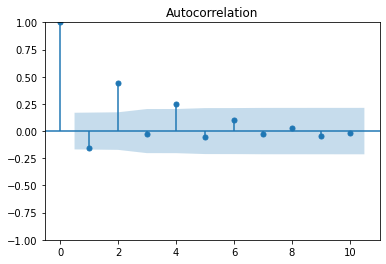

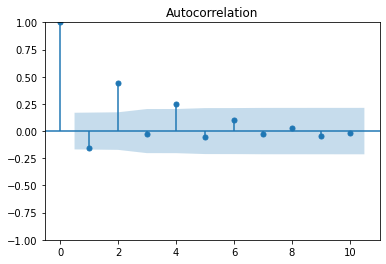

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 2)'>

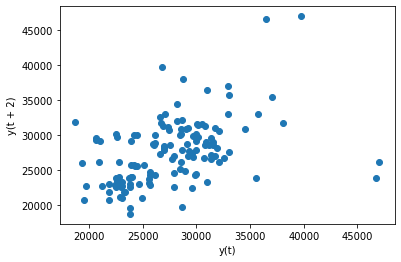

In [162]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa import stattools

stattools.acf(df_store_1_weekly_sum['Sales'], nlags=10)
plot_acf(df_store_1_weekly_sum['Sales'], lags=10)
plt.show()

lag_plot(series=df_store_1_weekly_sum['Sales'], lag=2)
plt.show()

## Monthly lags -> Forecast Monthly sales

array([ 1.        ,  0.25475426, -0.18232493, -0.2227541 , -0.02832462,
       -0.06339447, -0.29920826, -0.03256553,  0.06159573,  0.08253714,
       -0.03882617,  0.10088893,  0.34431472,  0.03753221, -0.13484324])

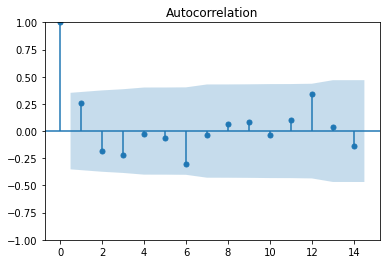

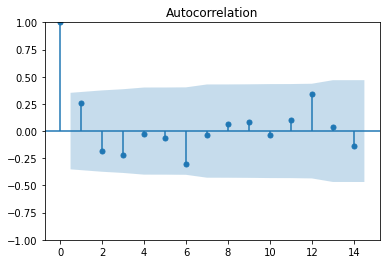

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 12)'>

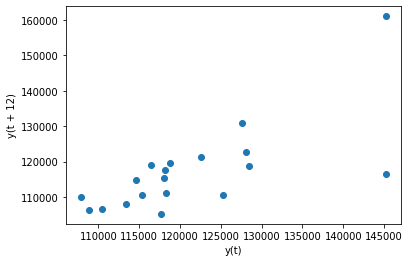

In [163]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa import stattools

stattools.acf(df_store_1_monthly_sum['Sales'], nlags=14)
plot_acf(df_store_1_monthly_sum['Sales'], lags=14)
plt.show()

lag_plot(series=df_store_1_monthly_sum['Sales'], lag=12)
plt.show()

## Daily lags -> Forecast Daily sales

array([ 1.        ,  0.6823286 ,  0.48088524,  0.26951029,  0.19847229,
        0.01460588, -0.03032239, -0.05670525, -0.00899662,  0.05521325,
        0.17090336,  0.27592809,  0.33288   ,  0.28231846,  0.18170799,
        0.09378321,  0.03730318, -0.01911521, -0.0607214 , -0.07238595,
       -0.0233293 ,  0.06226798,  0.16558096,  0.24687202,  0.29748263,
        0.25510048,  0.18066508,  0.11138269,  0.04826294, -0.05883629,
       -0.1295864 , -0.16399614])

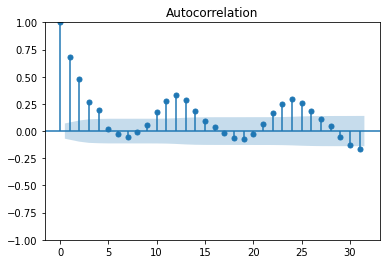

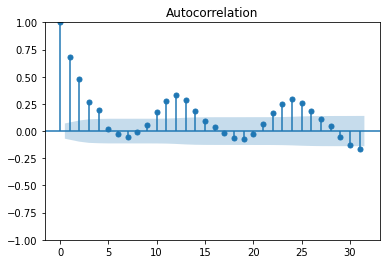

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 12)'>

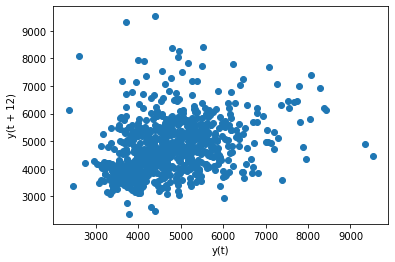

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 1)'>

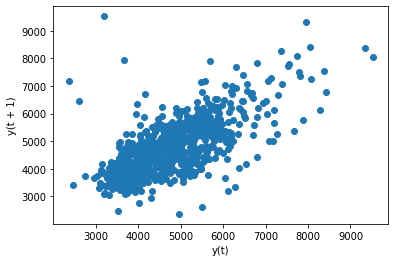

In [164]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa import stattools
import matplotlib.pyplot as plt

stattools.acf(df_train_store_1['Sales'], nlags=31)
plot_acf(df_train_store_1['Sales'], lags=31)
plt.show()

lag_plot(series=df_train_store_1['Sales'], lag=12)
plt.show()

lag_plot(series=df_train_store_1['Sales'], lag=1)
plt.show()